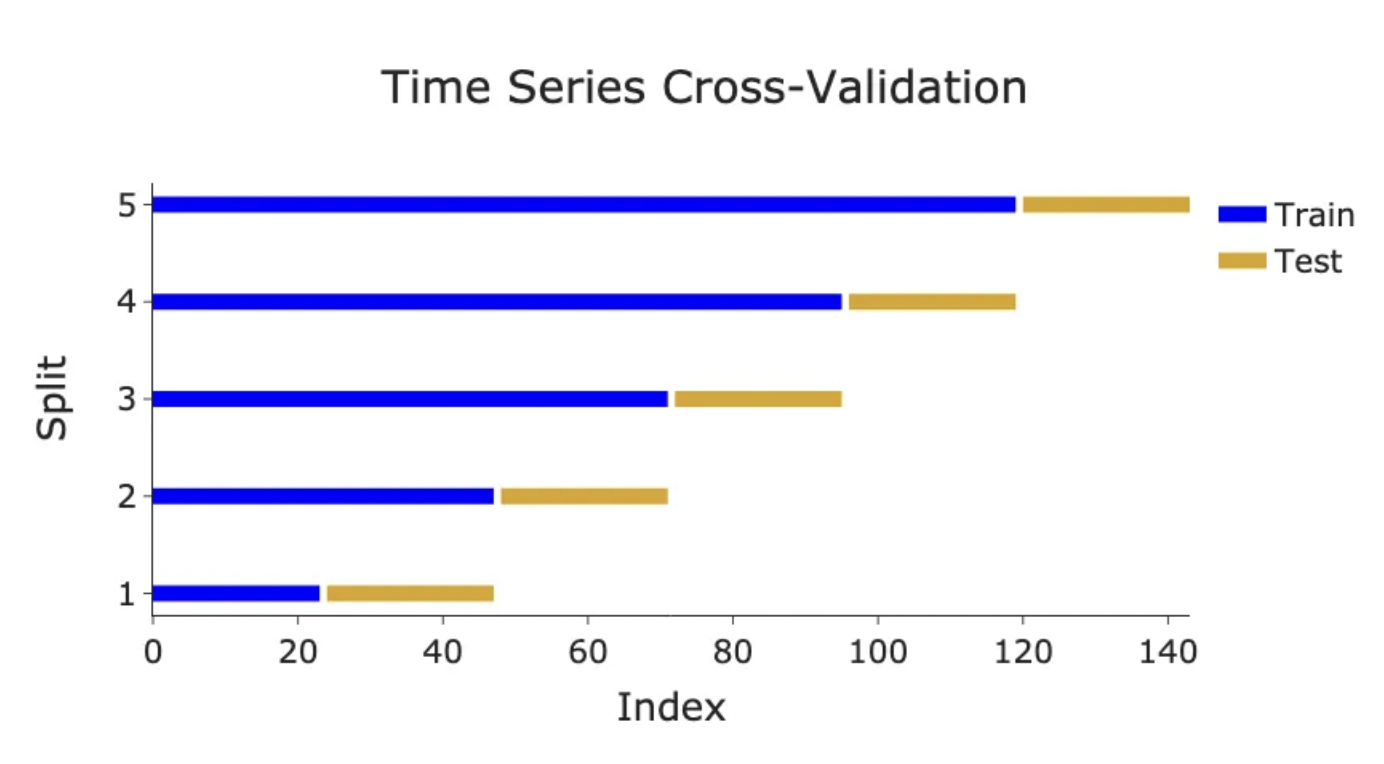

In [3]:
import pandas as pd
import re

df = pd.read_csv('/Users/baby_cow/Desktop/AI/ML_competition/data/geocoded_addresses_5.csv')
df['계약년'] = df['계약년월'].map(lambda x : int(str(x)[:4]))
df['계약월'] = df['계약년월'].map(lambda x : int(str(x)[4:]))
df['전용면적'] = df['전용면적(㎡)']
df = df.drop(['계약년월', '전용면적(㎡)', '본번', '부번', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', 'address', 'address_apt', 'address_apt_sqm' ], axis=1)
df = df.rename(columns=lambda x: re.sub('k-', '', x))

for col in df.columns:
    if df[col].dtype == 'object':
        df = df.drop(columns=[col], axis=1)

train_df = df.query("is_test == 0")
test_df = df.query("is_test == 1")

train_df = train_df.drop(columns=['is_test'], axis=1)
test_df = test_df.drop(columns=['is_test'], axis=1)

print(df.columns)

Index(['계약일', '층', '건축년도', '전체동수', '전체세대수', '연면적', '주거전용면적', '관리비부과면적',
       '전용면적별세대현황(60㎡이하)', '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과',
       '건축면적', '주차대수', 'target', 'is_test', 'latitude', 'longitude', '강남여부',
       'mean_target', 'apt_mean_target', 'address_mean_target',
       'mean_target_gu_dong', '계약년', '계약월', '전용면적'],
      dtype='object')


In [4]:
chunks = {}

for year in sorted(list(train_df["계약년"].unique())):
    chunks[year] = train_df[train_df["계약년"] == year]
    print(year, len(chunks[year]))


2007 58767
2008 57012
2009 73491
2010 44457
2011 54513
2012 40851
2013 67865
2014 85130
2015 119891
2016 99253
2017 104893
2018 81413
2019 74696
2020 83711
2021 43117
2022 12214
2023 17548


# Model

In [27]:
import lightgbm
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import random
import os

# 시드 고정 함수
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    lightgbm.seed = seed

set_seed(42)

In [28]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.001,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Initialize and train the model with early stopping and verbose evaluation
model = lgb.LGBMRegressor(**params, n_estimators=500, random_state=42)


In [29]:
from tqdm import tqdm

result_board = []

for val_year in tqdm(chunks.keys()):
    if val_year == 2007:
        continue

    X_train = chunks[2007].drop(columns=['target'], axis=1)
    y_train = chunks[2007]['target']
    
    for train_year in range(2008, val_year):
        new_X_train = chunks[train_year].drop(columns=['target'], axis=1)
        new_y_train = chunks[train_year]['target']

        X_train = pd.concat([X_train, new_X_train])
        y_train = pd.concat([y_train, new_y_train])
        

    X_val = chunks[val_year].drop(columns=['target'], axis = 1)
    y_val = chunks[val_year]['target']

    model.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks = [lgb.log_evaluation(1), lgb.early_stopping(10)])
    
    pred = model.predict(X_val)

    mse = mean_squared_error(y_val, pred)
    rmse = np.sqrt(mse)
    
    result_board.append({'val_year' : val_year, 'rmse' : rmse})



  0%|          | 0/17 [00:00<?, ?it/s]

[1]	valid_0's rmse: 26655.7
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 26630.4
[3]	valid_0's rmse: 26605
[4]	valid_0's rmse: 26579.7
[5]	valid_0's rmse: 26554.5
[6]	valid_0's rmse: 26529.2
[7]	valid_0's rmse: 26503.9
[8]	valid_0's rmse: 26478.7
[9]	valid_0's rmse: 26453.6
[10]	valid_0's rmse: 26428.4
[11]	valid_0's rmse: 26403.3
[12]	valid_0's rmse: 26378.1
[13]	valid_0's rmse: 26353.1
[14]	valid_0's rmse: 26328
[15]	valid_0's rmse: 26302.9
[16]	valid_0's rmse: 26277.5
[17]	valid_0's rmse: 26252.4
[18]	valid_0's rmse: 26227.1
[19]	valid_0's rmse: 26201.8
[20]	valid_0's rmse: 26176.6
[21]	valid_0's rmse: 26151.4
[22]	valid_0's rmse: 26127.7
[23]	valid_0's rmse: 26102.7
[24]	valid_0's rmse: 26077.6
[25]	valid_0's rmse: 26052.6
[26]	valid_0's rmse: 26027.9
[27]	valid_0's rmse: 26004.6
[28]	valid_0's rmse: 25979.9
[29]	valid_0's rmse: 25955.3
[30]	valid_0's rmse: 25930.7
[31]	valid_0's rmse: 25907.3
[32]	valid_0's rmse: 25882.7
[33]	valid_0's rmse: 258

 12%|█▏        | 2/17 [00:03<00:24,  1.63s/it]

[1]	valid_0's rmse: 37631.5
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 37598.3
[3]	valid_0's rmse: 37562.5
[4]	valid_0's rmse: 37526.6
[5]	valid_0's rmse: 37491
[6]	valid_0's rmse: 37455
[7]	valid_0's rmse: 37419.1
[8]	valid_0's rmse: 37383.2
[9]	valid_0's rmse: 37347.3
[10]	valid_0's rmse: 37311.5
[11]	valid_0's rmse: 37276.2
[12]	valid_0's rmse: 37240.7
[13]	valid_0's rmse: 37205.3
[14]	valid_0's rmse: 37170
[15]	valid_0's rmse: 37134.8
[16]	valid_0's rmse: 37099.9
[17]	valid_0's rmse: 37065
[18]	valid_0's rmse: 37030.1
[19]	valid_0's rmse: 36994.7
[20]	valid_0's rmse: 36961.7
[21]	valid_0's rmse: 36926.3
[22]	valid_0's rmse: 36890.9
[23]	valid_0's rmse: 36855.6
[24]	valid_0's rmse: 36820.4
[25]	valid_0's rmse: 36785.2
[26]	valid_0's rmse: 36750.2
[27]	valid_0's rmse: 36715.3
[28]	valid_0's rmse: 36682.6
[29]	valid_0's rmse: 36647.7
[30]	valid_0's rmse: 36615.1
[31]	valid_0's rmse: 36580.2
[32]	valid_0's rmse: 36545.4
[33]	valid_0's rmse: 36510.6

 18%|█▊        | 3/17 [00:07<00:38,  2.75s/it]

[1]	valid_0's rmse: 36225.9
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 36193.7
[3]	valid_0's rmse: 36159.7
[4]	valid_0's rmse: 36125.4
[5]	valid_0's rmse: 36091.4
[6]	valid_0's rmse: 36057.4
[7]	valid_0's rmse: 36023.4
[8]	valid_0's rmse: 35989.4
[9]	valid_0's rmse: 35955.6
[10]	valid_0's rmse: 35921.7
[11]	valid_0's rmse: 35887.8
[12]	valid_0's rmse: 35853.9
[13]	valid_0's rmse: 35820
[14]	valid_0's rmse: 35786.2
[15]	valid_0's rmse: 35752.4
[16]	valid_0's rmse: 35718.9
[17]	valid_0's rmse: 35685.3
[18]	valid_0's rmse: 35651.9
[19]	valid_0's rmse: 35618.3
[20]	valid_0's rmse: 35586.6
[21]	valid_0's rmse: 35553.2
[22]	valid_0's rmse: 35519.9
[23]	valid_0's rmse: 35486.5
[24]	valid_0's rmse: 35453.3
[25]	valid_0's rmse: 35420
[26]	valid_0's rmse: 35386.6
[27]	valid_0's rmse: 35353.2
[28]	valid_0's rmse: 35322
[29]	valid_0's rmse: 35288.7
[30]	valid_0's rmse: 35257.6
[31]	valid_0's rmse: 35224.5
[32]	valid_0's rmse: 35191.2
[33]	valid_0's rmse: 35157

 24%|██▎       | 4/17 [00:12<00:48,  3.71s/it]

[1]	valid_0's rmse: 30388.8
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 30360.2
[3]	valid_0's rmse: 30330.5
[4]	valid_0's rmse: 30300.6
[5]	valid_0's rmse: 30271
[6]	valid_0's rmse: 30241.4
[7]	valid_0's rmse: 30211.9
[8]	valid_0's rmse: 30182.5
[9]	valid_0's rmse: 30153
[10]	valid_0's rmse: 30123.6
[11]	valid_0's rmse: 30094.1
[12]	valid_0's rmse: 30064.6
[13]	valid_0's rmse: 30035.2
[14]	valid_0's rmse: 30005.8
[15]	valid_0's rmse: 29976.4
[16]	valid_0's rmse: 29947
[17]	valid_0's rmse: 29917.7
[18]	valid_0's rmse: 29888.6
[19]	valid_0's rmse: 29859
[20]	valid_0's rmse: 29830.7
[21]	valid_0's rmse: 29801.5
[22]	valid_0's rmse: 29772.3
[23]	valid_0's rmse: 29743.2
[24]	valid_0's rmse: 29714
[25]	valid_0's rmse: 29684.9
[26]	valid_0's rmse: 29655.9
[27]	valid_0's rmse: 29626.8
[28]	valid_0's rmse: 29598.8
[29]	valid_0's rmse: 29569.9
[30]	valid_0's rmse: 29541.9
[31]	valid_0's rmse: 29513.1
[32]	valid_0's rmse: 29484.2
[33]	valid_0's rmse: 29455.3
[

 29%|██▉       | 5/17 [00:18<00:53,  4.49s/it]

[1]	valid_0's rmse: 30549.1
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 30517.4
[3]	valid_0's rmse: 30484.4
[4]	valid_0's rmse: 30451.4
[5]	valid_0's rmse: 30418.5
[6]	valid_0's rmse: 30385.7
[7]	valid_0's rmse: 30352.8
[8]	valid_0's rmse: 30320.1
[9]	valid_0's rmse: 30287.3
[10]	valid_0's rmse: 30254.7
[11]	valid_0's rmse: 30221.9
[12]	valid_0's rmse: 30189.2
[13]	valid_0's rmse: 30156.5
[14]	valid_0's rmse: 30123.9
[15]	valid_0's rmse: 30091.3
[16]	valid_0's rmse: 30058.6
[17]	valid_0's rmse: 30026
[18]	valid_0's rmse: 29993.3
[19]	valid_0's rmse: 29960.9
[20]	valid_0's rmse: 29929.5
[21]	valid_0's rmse: 29897
[22]	valid_0's rmse: 29864.6
[23]	valid_0's rmse: 29832.2
[24]	valid_0's rmse: 29799.9
[25]	valid_0's rmse: 29767.5
[26]	valid_0's rmse: 29735.3
[27]	valid_0's rmse: 29703.1
[28]	valid_0's rmse: 29672.2
[29]	valid_0's rmse: 29640.2
[30]	valid_0's rmse: 29609.3
[31]	valid_0's rmse: 29577.1
[32]	valid_0's rmse: 29544.9
[33]	valid_0's rmse: 295

 35%|███▌      | 6/17 [00:25<00:56,  5.15s/it]

[1]	valid_0's rmse: 29463.5
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 29432.7
[3]	valid_0's rmse: 29400.8
[4]	valid_0's rmse: 29368.7
[5]	valid_0's rmse: 29336.9
[6]	valid_0's rmse: 29305
[7]	valid_0's rmse: 29273.1
[8]	valid_0's rmse: 29241.4
[9]	valid_0's rmse: 29209.6
[10]	valid_0's rmse: 29177.8
[11]	valid_0's rmse: 29146.1
[12]	valid_0's rmse: 29114.3
[13]	valid_0's rmse: 29082.6
[14]	valid_0's rmse: 29051
[15]	valid_0's rmse: 29019.3
[16]	valid_0's rmse: 28987.6
[17]	valid_0's rmse: 28955.9
[18]	valid_0's rmse: 28924.4
[19]	valid_0's rmse: 28892.6
[20]	valid_0's rmse: 28862.2
[21]	valid_0's rmse: 28830.7
[22]	valid_0's rmse: 28799.2
[23]	valid_0's rmse: 28767.8
[24]	valid_0's rmse: 28736.3
[25]	valid_0's rmse: 28704.9
[26]	valid_0's rmse: 28673.6
[27]	valid_0's rmse: 28642.3
[28]	valid_0's rmse: 28612.3
[29]	valid_0's rmse: 28581.1
[30]	valid_0's rmse: 28551.1
[31]	valid_0's rmse: 28520.1
[32]	valid_0's rmse: 28489
[33]	valid_0's rmse: 28458

 41%|████      | 7/17 [00:32<00:58,  5.85s/it]

[1]	valid_0's rmse: 31335.5
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 31305.4
[3]	valid_0's rmse: 31275
[4]	valid_0's rmse: 31243.2
[5]	valid_0's rmse: 31212.9
[6]	valid_0's rmse: 31183.2
[7]	valid_0's rmse: 31153.6
[8]	valid_0's rmse: 31124.1
[9]	valid_0's rmse: 31094.5
[10]	valid_0's rmse: 31065
[11]	valid_0's rmse: 31035.3
[12]	valid_0's rmse: 31005.4
[13]	valid_0's rmse: 30975.9
[14]	valid_0's rmse: 30946.3
[15]	valid_0's rmse: 30916.5
[16]	valid_0's rmse: 30886.8
[17]	valid_0's rmse: 30857.1
[18]	valid_0's rmse: 30827.8
[19]	valid_0's rmse: 30798
[20]	valid_0's rmse: 30768.3
[21]	valid_0's rmse: 30739.1
[22]	valid_0's rmse: 30709.9
[23]	valid_0's rmse: 30680.7
[24]	valid_0's rmse: 30651.5
[25]	valid_0's rmse: 30622.4
[26]	valid_0's rmse: 30592.8
[27]	valid_0's rmse: 30563.2
[28]	valid_0's rmse: 30533.9
[29]	valid_0's rmse: 30504.6
[30]	valid_0's rmse: 30475.3
[31]	valid_0's rmse: 30446.4
[32]	valid_0's rmse: 30417.6
[33]	valid_0's rmse: 30388

 47%|████▋     | 8/17 [00:41<01:00,  6.67s/it]

[1]	valid_0's rmse: 31584.3
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 31556.2
[3]	valid_0's rmse: 31528
[4]	valid_0's rmse: 31498.5
[5]	valid_0's rmse: 31470.3
[6]	valid_0's rmse: 31442
[7]	valid_0's rmse: 31413.7
[8]	valid_0's rmse: 31385.5
[9]	valid_0's rmse: 31357.2
[10]	valid_0's rmse: 31329.2
[11]	valid_0's rmse: 31300.9
[12]	valid_0's rmse: 31272.6
[13]	valid_0's rmse: 31244.4
[14]	valid_0's rmse: 31216.6
[15]	valid_0's rmse: 31188.4
[16]	valid_0's rmse: 31160.5
[17]	valid_0's rmse: 31132.6
[18]	valid_0's rmse: 31104.7
[19]	valid_0's rmse: 31077
[20]	valid_0's rmse: 31049.3
[21]	valid_0's rmse: 31021.3
[22]	valid_0's rmse: 30993.4
[23]	valid_0's rmse: 30965.5
[24]	valid_0's rmse: 30937.7
[25]	valid_0's rmse: 30909.8
[26]	valid_0's rmse: 30882.4
[27]	valid_0's rmse: 30855
[28]	valid_0's rmse: 30827.6
[29]	valid_0's rmse: 30800.3
[30]	valid_0's rmse: 30773
[31]	valid_0's rmse: 30745.5
[32]	valid_0's rmse: 30718.1
[33]	valid_0's rmse: 30690.8
[

 53%|█████▎    | 9/17 [00:50<01:00,  7.54s/it]

[1]	valid_0's rmse: 37036.9
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 37006.7
[3]	valid_0's rmse: 36974.3
[4]	valid_0's rmse: 36941.4
[5]	valid_0's rmse: 36908.8
[6]	valid_0's rmse: 36876
[7]	valid_0's rmse: 36843.3
[8]	valid_0's rmse: 36810.7
[9]	valid_0's rmse: 36778
[10]	valid_0's rmse: 36745.5
[11]	valid_0's rmse: 36713.4
[12]	valid_0's rmse: 36681.3
[13]	valid_0's rmse: 36649.3
[14]	valid_0's rmse: 36617.7
[15]	valid_0's rmse: 36585.7
[16]	valid_0's rmse: 36553.4
[17]	valid_0's rmse: 36521.1
[18]	valid_0's rmse: 36488.8
[19]	valid_0's rmse: 36456.6
[20]	valid_0's rmse: 36426.9
[21]	valid_0's rmse: 36394.8
[22]	valid_0's rmse: 36362.4
[23]	valid_0's rmse: 36330.1
[24]	valid_0's rmse: 36297.9
[25]	valid_0's rmse: 36266
[26]	valid_0's rmse: 36234.2
[27]	valid_0's rmse: 36202.4
[28]	valid_0's rmse: 36173
[29]	valid_0's rmse: 36141.4
[30]	valid_0's rmse: 36112
[31]	valid_0's rmse: 36079.9
[32]	valid_0's rmse: 36047.8
[33]	valid_0's rmse: 36015.7
[

 59%|█████▉    | 10/17 [01:01<00:59,  8.57s/it]

[1]	valid_0's rmse: 45099.3
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 45067.2
[3]	valid_0's rmse: 45032.1
[4]	valid_0's rmse: 44997
[5]	valid_0's rmse: 44961.9
[6]	valid_0's rmse: 44927.1
[7]	valid_0's rmse: 44892.1
[8]	valid_0's rmse: 44857.4
[9]	valid_0's rmse: 44822.4
[10]	valid_0's rmse: 44787.6
[11]	valid_0's rmse: 44752.9
[12]	valid_0's rmse: 44718.2
[13]	valid_0's rmse: 44683.5
[14]	valid_0's rmse: 44649
[15]	valid_0's rmse: 44614.4
[16]	valid_0's rmse: 44579.9
[17]	valid_0's rmse: 44545.4
[18]	valid_0's rmse: 44510.9
[19]	valid_0's rmse: 44476.6
[20]	valid_0's rmse: 44445.5
[21]	valid_0's rmse: 44411.2
[22]	valid_0's rmse: 44376.9
[23]	valid_0's rmse: 44342.7
[24]	valid_0's rmse: 44308.4
[25]	valid_0's rmse: 44274.7
[26]	valid_0's rmse: 44240.5
[27]	valid_0's rmse: 44206.9
[28]	valid_0's rmse: 44176.2
[29]	valid_0's rmse: 44142
[30]	valid_0's rmse: 44111.3
[31]	valid_0's rmse: 44077.9
[32]	valid_0's rmse: 44044.6
[33]	valid_0's rmse: 44011

 65%|██████▍   | 11/17 [01:14<00:58,  9.81s/it]

[1]	valid_0's rmse: 50755.1
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 50718.4
[3]	valid_0's rmse: 50681.8
[4]	valid_0's rmse: 50645.2
[5]	valid_0's rmse: 50608.7
[6]	valid_0's rmse: 50571.8
[7]	valid_0's rmse: 50539.4
[8]	valid_0's rmse: 50503.3
[9]	valid_0's rmse: 50467.2
[10]	valid_0's rmse: 50431.1
[11]	valid_0's rmse: 50394.6
[12]	valid_0's rmse: 50358.1
[13]	valid_0's rmse: 50321.6
[14]	valid_0's rmse: 50285.2
[15]	valid_0's rmse: 50248.8
[16]	valid_0's rmse: 50213
[17]	valid_0's rmse: 50177
[18]	valid_0's rmse: 50141.1
[19]	valid_0's rmse: 50105.4
[20]	valid_0's rmse: 50069.6
[21]	valid_0's rmse: 50033.7
[22]	valid_0's rmse: 49997.6
[23]	valid_0's rmse: 49962
[24]	valid_0's rmse: 49926.3
[25]	valid_0's rmse: 49894.1
[26]	valid_0's rmse: 49859.1
[27]	valid_0's rmse: 49827.5
[28]	valid_0's rmse: 49792.5
[29]	valid_0's rmse: 49757.6
[30]	valid_0's rmse: 49722.8
[31]	valid_0's rmse: 49687.4
[32]	valid_0's rmse: 49655.9
[33]	valid_0's rmse: 49621

 71%|███████   | 12/17 [01:28<00:55, 11.13s/it]

[1]	valid_0's rmse: 65958.9
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 65913.2
[3]	valid_0's rmse: 65867.6
[4]	valid_0's rmse: 65822.1
[5]	valid_0's rmse: 65775.6
[6]	valid_0's rmse: 65741
[7]	valid_0's rmse: 65699.7
[8]	valid_0's rmse: 65653.6
[9]	valid_0's rmse: 65607.4
[10]	valid_0's rmse: 65561.7
[11]	valid_0's rmse: 65515.7
[12]	valid_0's rmse: 65469.8
[13]	valid_0's rmse: 65423.9
[14]	valid_0's rmse: 65377.9
[15]	valid_0's rmse: 65330.5
[16]	valid_0's rmse: 65284.9
[17]	valid_0's rmse: 65238.3
[18]	valid_0's rmse: 65192.7
[19]	valid_0's rmse: 65146
[20]	valid_0's rmse: 65100.6
[21]	valid_0's rmse: 65054.6
[22]	valid_0's rmse: 65008.6
[23]	valid_0's rmse: 64962.5
[24]	valid_0's rmse: 64916.7
[25]	valid_0's rmse: 64876.2
[26]	valid_0's rmse: 64831.1
[27]	valid_0's rmse: 64791
[28]	valid_0's rmse: 64745.5
[29]	valid_0's rmse: 64700.7
[30]	valid_0's rmse: 64655.6
[31]	valid_0's rmse: 64609.6
[32]	valid_0's rmse: 64569.2
[33]	valid_0's rmse: 64523

 76%|███████▋  | 13/17 [01:44<00:50, 12.64s/it]

[1]	valid_0's rmse: 65492.3
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 65444
[3]	valid_0's rmse: 65395.8
[4]	valid_0's rmse: 65347.6
[5]	valid_0's rmse: 65299.5
[6]	valid_0's rmse: 65268.7
[7]	valid_0's rmse: 65223.4
[8]	valid_0's rmse: 65175.2
[9]	valid_0's rmse: 65127.3
[10]	valid_0's rmse: 65079.3
[11]	valid_0's rmse: 65031.5
[12]	valid_0's rmse: 64983.8
[13]	valid_0's rmse: 64936.2
[14]	valid_0's rmse: 64888.6
[15]	valid_0's rmse: 64841.1
[16]	valid_0's rmse: 64793.3
[17]	valid_0's rmse: 64745.6
[18]	valid_0's rmse: 64698
[19]	valid_0's rmse: 64650.6
[20]	valid_0's rmse: 64603
[21]	valid_0's rmse: 64555.7
[22]	valid_0's rmse: 64508.4
[23]	valid_0's rmse: 64461.1
[24]	valid_0's rmse: 64413.7
[25]	valid_0's rmse: 64369.2
[26]	valid_0's rmse: 64322.2
[27]	valid_0's rmse: 64277.8
[28]	valid_0's rmse: 64231
[29]	valid_0's rmse: 64184.1
[30]	valid_0's rmse: 64137.3
[31]	valid_0's rmse: 64090.3
[32]	valid_0's rmse: 64046.1
[33]	valid_0's rmse: 63999.1

 82%|████████▏ | 14/17 [02:01<00:42, 14.11s/it]

[1]	valid_0's rmse: 89020.4
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 88960.3
[3]	valid_0's rmse: 88900.4
[4]	valid_0's rmse: 88840.5
[5]	valid_0's rmse: 88780.9
[6]	valid_0's rmse: 88742.7
[7]	valid_0's rmse: 88687.4
[8]	valid_0's rmse: 88628.2
[9]	valid_0's rmse: 88568.7
[10]	valid_0's rmse: 88509.6
[11]	valid_0's rmse: 88450.6
[12]	valid_0's rmse: 88391.6
[13]	valid_0's rmse: 88332.7
[14]	valid_0's rmse: 88273.8
[15]	valid_0's rmse: 88214.5
[16]	valid_0's rmse: 88155.4
[17]	valid_0's rmse: 88096.6
[18]	valid_0's rmse: 88037.9
[19]	valid_0's rmse: 87979
[20]	valid_0's rmse: 87920.2
[21]	valid_0's rmse: 87861.7
[22]	valid_0's rmse: 87803.2
[23]	valid_0's rmse: 87744.9
[24]	valid_0's rmse: 87686.7
[25]	valid_0's rmse: 87633.1
[26]	valid_0's rmse: 87575.1
[27]	valid_0's rmse: 87520.9
[28]	valid_0's rmse: 87462.7
[29]	valid_0's rmse: 87404.5
[30]	valid_0's rmse: 87346.7
[31]	valid_0's rmse: 87289.1
[32]	valid_0's rmse: 87235.2
[33]	valid_0's rmse: 8

 88%|████████▊ | 15/17 [02:19<00:30, 15.29s/it]

[1]	valid_0's rmse: 104764
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 104689
[3]	valid_0's rmse: 104615
[4]	valid_0's rmse: 104541
[5]	valid_0's rmse: 104468
[6]	valid_0's rmse: 104419
[7]	valid_0's rmse: 104353
[8]	valid_0's rmse: 104281
[9]	valid_0's rmse: 104208
[10]	valid_0's rmse: 104136
[11]	valid_0's rmse: 104063
[12]	valid_0's rmse: 103990
[13]	valid_0's rmse: 103917
[14]	valid_0's rmse: 103844
[15]	valid_0's rmse: 103770
[16]	valid_0's rmse: 103699
[17]	valid_0's rmse: 103627
[18]	valid_0's rmse: 103555
[19]	valid_0's rmse: 103482
[20]	valid_0's rmse: 103410
[21]	valid_0's rmse: 103338
[22]	valid_0's rmse: 103266
[23]	valid_0's rmse: 103195
[24]	valid_0's rmse: 103123
[25]	valid_0's rmse: 103058
[26]	valid_0's rmse: 102986
[27]	valid_0's rmse: 102923
[28]	valid_0's rmse: 102850
[29]	valid_0's rmse: 102778
[30]	valid_0's rmse: 102706
[31]	valid_0's rmse: 102634
[32]	valid_0's rmse: 102569
[33]	valid_0's rmse: 102497
[34]	valid_0's rmse: 102

 94%|█████████▍| 16/17 [02:37<00:15, 15.92s/it]

[1]	valid_0's rmse: 86601.6
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 86523
[3]	valid_0's rmse: 86446.9
[4]	valid_0's rmse: 86368.6
[5]	valid_0's rmse: 86291
[6]	valid_0's rmse: 86244.8
[7]	valid_0's rmse: 86163.2
[8]	valid_0's rmse: 86087.2
[9]	valid_0's rmse: 86011.3
[10]	valid_0's rmse: 85935.5
[11]	valid_0's rmse: 85858.8
[12]	valid_0's rmse: 85782
[13]	valid_0's rmse: 85705.5
[14]	valid_0's rmse: 85628.9
[15]	valid_0's rmse: 85553.3
[16]	valid_0's rmse: 85477.8
[17]	valid_0's rmse: 85402.5
[18]	valid_0's rmse: 85326.2
[19]	valid_0's rmse: 85248.7
[20]	valid_0's rmse: 85172.5
[21]	valid_0's rmse: 85098.7
[22]	valid_0's rmse: 85025
[23]	valid_0's rmse: 84951.4
[24]	valid_0's rmse: 84877.9
[25]	valid_0's rmse: 84803.2
[26]	valid_0's rmse: 84725.8
[27]	valid_0's rmse: 84647.7
[28]	valid_0's rmse: 84571.4
[29]	valid_0's rmse: 84495.9
[30]	valid_0's rmse: 84418.8
[31]	valid_0's rmse: 84344.7
[32]	valid_0's rmse: 84268.6
[33]	valid_0's rmse: 84191.2

100%|██████████| 17/17 [02:55<00:00, 10.30s/it]


/var/folders/2k/0xqbdwyx3fl_nkksxt394mqw0000gn/T/ipykernel_1400/2180684573.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = result_board_df, x = 'val_year', y='rmse', palette='Set2')


<Axes: xlabel='val_year', ylabel='rmse'>

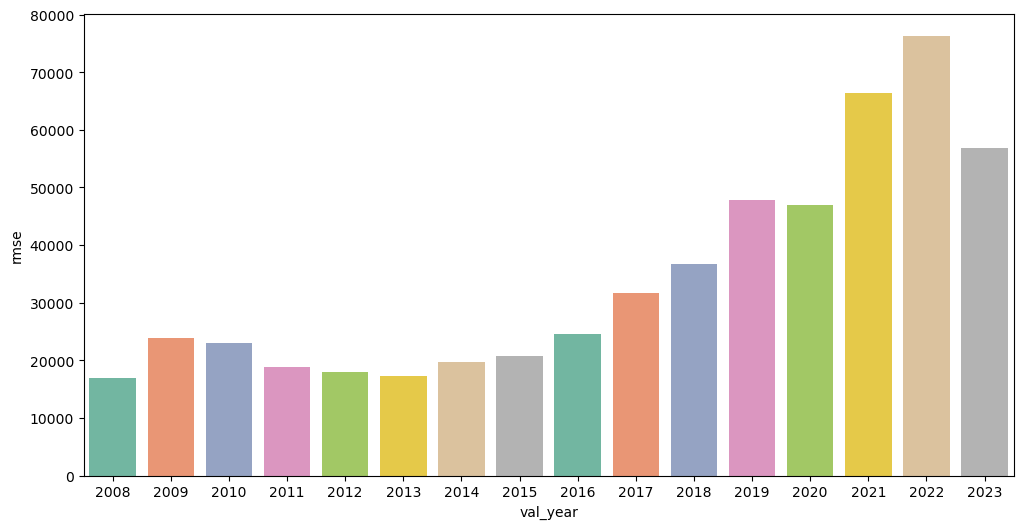

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

result_board_df = pd.DataFrame(result_board)

plt.figure(figsize=(12, 6))
sns.barplot(data = result_board_df, x = 'val_year', y='rmse', palette='Set2')

In [31]:
result_board_df

,val_year,rmse
0,2008,16955.852073
1,2009,23836.514342
2,2010,23052.328169
3,2011,18890.987181
4,2012,17913.839934
5,2013,17305.696439
6,2014,19702.360367
7,2015,20687.203776
8,2016,24558.487268
9,2017,31650.378210


In [32]:
X_train = train_df.drop(columns=['target'], axis=1)
y_train = train_df['target']

model.fit(X_train, y_train)

pred = model.predict(test_df)

submit_df = pd.DataFrame(columns=['target'], data=pred)
submit_df.head()


,target
0,110395.967679
1,136324.667649
2,137312.722079
3,123786.461295
4,111236.641315


In [33]:
submit_df['target'] = submit_df['target'].astype(int)
submit_df.to_csv('imeseries_val.csv', index=False)

## 방법 2

In [20]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.001,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Initialize and train the model with early stopping and verbose evaluation
model = lgb.LGBMRegressor(**params, n_estimators=5000, random_state=42)

In [21]:
import lightgbm
from sklearn.metrics import mean_squared_error
import numpy as np

result_board = []

for val_year in chunks.keys():
    if val_year == 2007:
        continue

    train_year = val_year - 1
    X_train = chunks[train_year].drop(columns=['target'], axis=1)
    y_train = chunks[train_year]['target']

    X_val = chunks[val_year].drop(columns=['target'], axis = 1)
    y_val = chunks[val_year]['target']

    model.fit(X_train, y_train)
    pred = model.predict(X_val)

    mse = mean_squared_error(y_val, pred)
    rmse = np.sqrt(mse)
    
    result_board.append({'val_year' : val_year, 'rmse' : rmse})


/var/folders/2k/0xqbdwyx3fl_nkksxt394mqw0000gn/T/ipykernel_1400/2180684573.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = result_board_df, x = 'val_year', y='rmse', palette='Set2')


<Axes: xlabel='val_year', ylabel='rmse'>

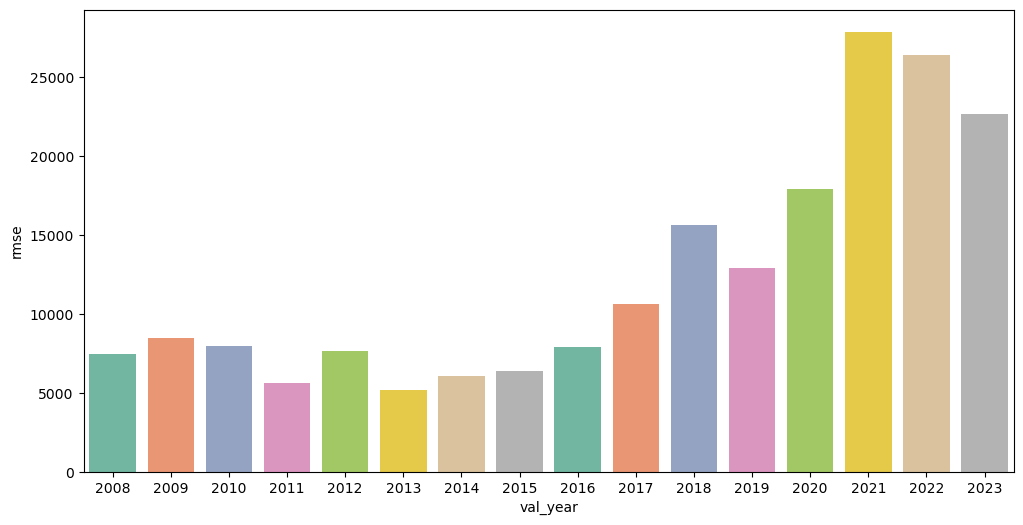

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

result_board_df = pd.DataFrame(result_board)

plt.figure(figsize=(12, 6))
sns.barplot(data = result_board_df, x = 'val_year', y='rmse', palette='Set2')

In [23]:
result_board_df

,val_year,rmse
0,2008,7451.524500
1,2009,8493.431462
2,2010,7993.629943
3,2011,5612.175584
4,2012,7620.355439
5,2013,5175.501529
6,2014,6091.956817
7,2015,6387.206182
8,2016,7872.420773
9,2017,10612.431541


In [25]:
X_train = train_df.drop(columns=['target'], axis=1)
y_train = train_df['target']

model.fit(X_train, y_train)

pred = model.predict(test_df)

submit_df = pd.DataFrame(columns=['target'], data=pred)
submit_df['target'] = submit_df['target'].astype(int)
submit_df.head()

,target
0,211452
1,257667
2,295480
3,245600
4,215751


In [26]:
submit_df.to_csv('timeseries_val2.csv', index=False)